# MODIS time series and global distributions

TIWP is available in MODIS as L3 daily means. Only cloudy pixels are used in the aggregation, so the L3 IWP needs to be multiplied by ice cloud fraction to obtain the TIWP across the entire pixel. Water path values are derived using visible channels, so TIWP is only available for daytime.

Cloud fraction (CF) is also available as L3 daily means, and separate data exists for daytime-only, nighttime-only, and daytime+nighttime. L3 cloud fraction is derived from the L2 cloud mask.

To calculate a global distribution over, for example, a year, each L3 daily data point should be weighted with the corresponding counts for that day. This is the same method that the MODIS L3 monthly product uses for cloud optical properties.<br/>
There is a visible difference in the global distributions when using a weighted mean vs not weighted.<br/>
Since TIWP is also weighted with ice cloud fraction, there will be a small difference between statistics computed with L3 data and statistics computed over L2 data. For CF, there should not be a difference.

In [25]:
import os
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import cmocean as cmo
import geopandas as gpd

from matplotlib.colors import LogNorm

In [4]:
import jupyter_black

jupyter_black.load()

In [5]:
plt.style.use("../ccic.mplstyle")

# Interpolation/masking

Just a sanity check to see if all looks okay for a single day of data. Actual interpolation and masking is done as pre-processing step.

In [11]:
file_path = '/scratch/ccic_record/data/modis/ccic_modis_data_2022.nc'
dataset = xr.open_dataset(file_path)

mask = xr.open_dataset("../mask_24_for_modis.nc")
mask = mask.mask == 1

In [13]:
# Extract cloud fraction, remove any invalid data, and apply the masj
latitude = dataset["lat"][:]
longitude = dataset["lon"][:]
data = dataset["Cloud_Fraction_Mean"][220, :, :].values
data_filtered = np.where((data == -9999) | (data == -2147483647), np.nan, data)
data_filtered = data_filtered.astype(float) * 0.0001

mask_24 = xr.open_dataset("/scratch/ccic_record/data/mask_24.nc")

data_masked = dataset["Cloud_Fraction_Mean"].where(mask == 1)[220, :, :].values
data_filtered_masked = np.where(
    (data_masked == -9999) | (data_masked < -0), np.nan, data_masked
)
data_filtered_masked = data_filtered_masked.astype(float) * 0.0001

/tmp/ipykernel_8835/344799901.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


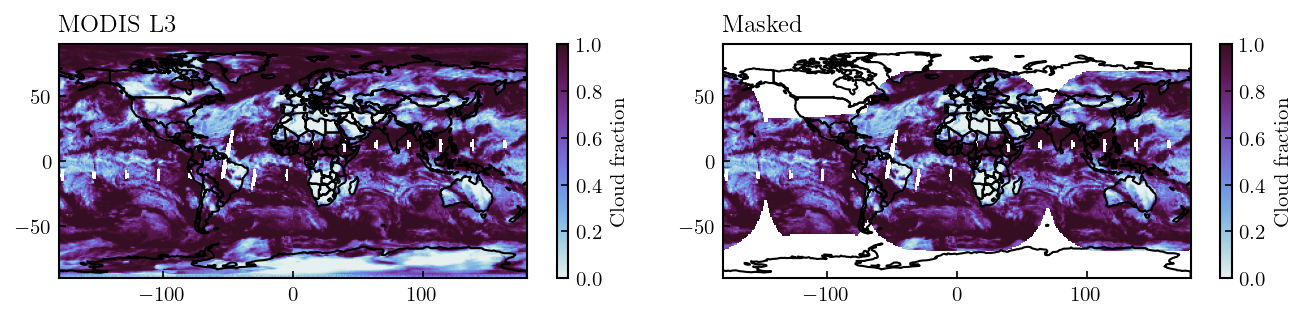

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 2))

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

extent = [
    longitude[0] - 0.5,
    longitude[-1] + 0.5,
    latitude[0] - 0.5,
    latitude[-1] + 0.5,
]

cax = axes[0].imshow(data_filtered, extent=extent)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction")
world.boundary.plot(ax=axes[0], color="black", lw=1)
axes[0].set_title(r"MODIS L3")

cax2 = axes[1].imshow(
    data_filtered_masked,
    extent=extent,
)
world.boundary.plot(ax=axes[1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"Cloud fraction")
axes[1].set_title(r"Masked")

fig.tight_layout()

# Time series

In [7]:
time_series = xr.open_dataset('/scratch/ccic_record/data/timeseries/modis_cf_tiwp_time_series.nc')

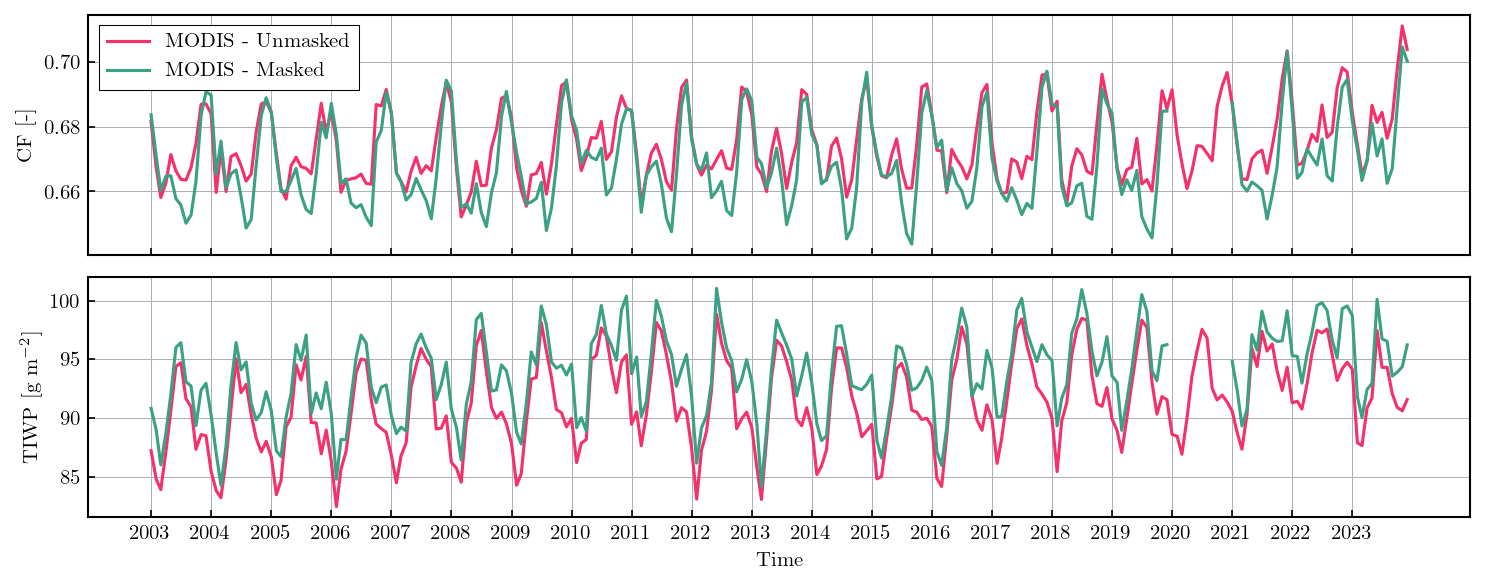

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4))

ax1.plot(time_series['date'], time_series['CF_global_mean_unmasked'].values, label='MODIS - Unmasked')
ax1.plot(time_series['date'], time_series['CF_global_mean_masked'].values, label='MODIS - Masked')

ax2.plot(time_series['date'], time_series['TIWP_global_mean_unmasked'].values, label='MODIS - Unmasked')
ax2.plot(time_series['date'], time_series['TIWP_global_mean_masked'].values, label='MODIS - Masked')

#ax.set_ylim([0.63, 0.715])
ax1.set_xticks(time_series['date'][::12])
ax2.set_xticks(time_series['date'][::12])
ax1.set_xticklabels([])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_xlabel('Time')

ax1.set_ylabel('CF [-]')
ax2.set_ylabel(r'TIWP [g m$^{-2}$]')

ax1.legend()

ax1.grid()
ax2.grid()

fig.tight_layout()

#plt.savefig(f'cf_tiwp_timeseries_modis.pdf', facecolor='white', bbox_inches="tight")

# Global distributions

In [23]:
global_distribution = xr.open_dataset("/scratch/ccic_record/data/global_distribution_cf_tiwp_modis.nc")

/tmp/ipykernel_8835/1060750141.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


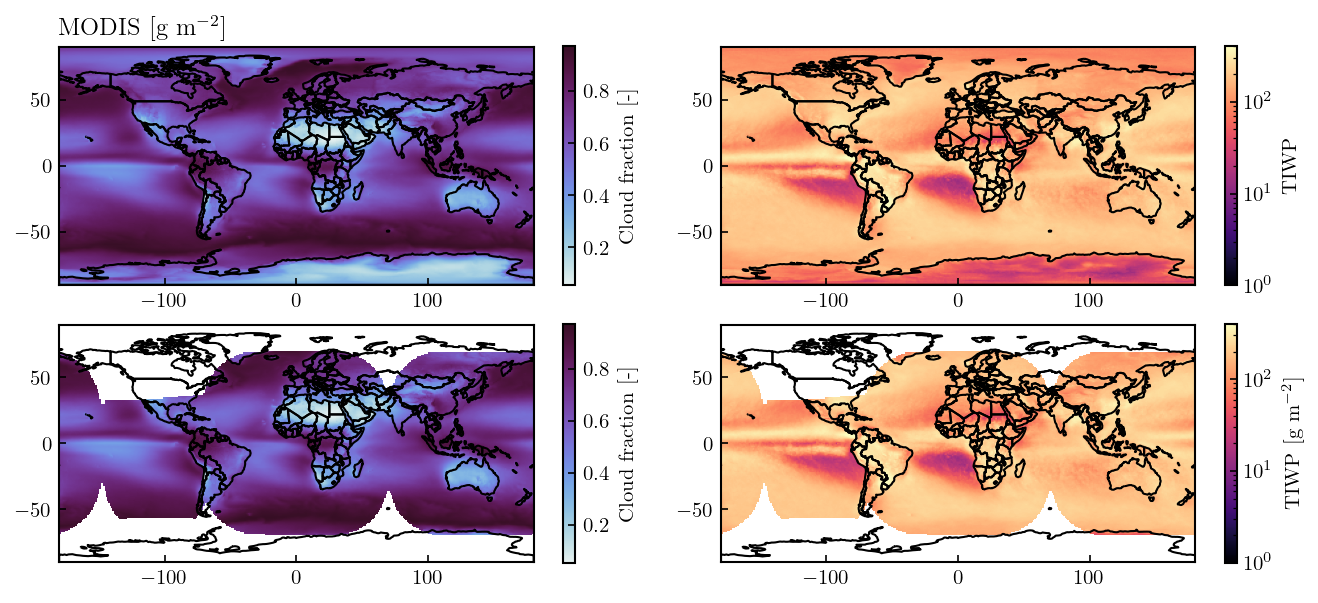

In [24]:
latitude = global_distribution["lat"][:]
longitude = global_distribution["lon"][:]

fig, axes = plt.subplots(2, 2, figsize=(9, 4))

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

extent = [
    longitude[0] - 0.5,
    longitude[-1] + 0.5,
    latitude[0] - 0.5,
    latitude[-1] + 0.5,
]

cax = axes[0, 0].imshow(
    global_distribution["CF_global_distribution_unmasked"], extent=extent
)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction [-]")
world.boundary.plot(ax=axes[0, 0], color="black", lw=1)
axes[0, 0].set_title(r"MODIS [g m$^{-2}$]")

cax2 = axes[0, 1].imshow(
    global_distribution["TIWP_global_distribution_unmasked"],
    extent=extent,
    norm=LogNorm(vmin=(1e0), vmax=4e2),
    cmap="magma",
)
world.boundary.plot(ax=axes[0, 1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"TIWP")

cax = axes[1, 0].imshow(
    global_distribution["CF_global_distribution_masked"], extent=extent
)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction [-]")
world.boundary.plot(ax=axes[1, 0], color="black", lw=1)

cax2 = axes[1, 1].imshow(
    global_distribution["TIWP_global_distribution_masked"],
    extent=extent,
    norm=LogNorm(vmin=(1e0), vmax=4e2),
    cmap="magma",
)
world.boundary.plot(ax=axes[1, 1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"TIWP [g m$^{-2}$]")

fig.tight_layout()